# Analysis

## Set-up data for the experiments

In [1]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_micro_cohort/final/data_matrix.csv''')
datamatrixDf

,person_id,visit_occurrence_id,measurement_date,visit_start_datetime_adm,death_datetime_adm,death_0_7_adm,death_0_14_adm,death_0_21_adm,death_0_30_adm,death_0_60_adm,...,labs_Prothrombin time (PT)_last,labs_INR in Platelet poor plasma by Coagulation assay_last,labs_aPTT in Blood by Coagulation assay_last,labs_Specific gravity of Urine by Test strip_last,labs_pH of Urine by Test strip_last,labs_Bilirubin.total in Serum or Plasma_last,labs_Aspartate aminotransferase in Serum or Plasma_last,labs_Alanine aminotransferase in Serum or Plasma_last,labs_Alkaline phosphatase in Serum or Plasma_last,labs_Albumin in Serum or Plasma_last
0,-1788739119,-2142878850,2159-05-24,2159-05-22 20:37:00,2159-09-18 00:00:00,0,0,0,0,0,...,15.9,1.5,32.500000,1.020300,6.620000,1.900000,38.000000,19.000000,154.000000,3.320500
1,-1788739119,-2142878850,2159-05-26,2159-05-22 20:37:00,2159-09-18 00:00:00,0,0,0,0,0,...,14.8,1.4,33.800000,1.016395,6.905000,2.328000,58.430000,43.331667,181.220000,2.836500
2,-1788739119,-2142878850,2159-05-27,2159-05-22 20:37:00,2159-09-18 00:00:00,0,0,0,0,0,...,12.5,1.1,35.900000,1.016577,6.820000,1.000000,27.000000,16.000000,151.000000,2.679500
3,-1788739119,-2142878850,2159-05-28,2159-05-22 20:37:00,2159-09-18 00:00:00,0,0,0,0,0,...,11.8,1.1,37.000000,1.015025,6.845000,2.486833,46.225000,67.945000,223.955000,2.695000
4,-1788739119,-2142878850,2159-05-29,2159-05-22 20:37:00,2159-09-18 00:00:00,0,0,0,0,0,...,12.2,1.1,40.841917,1.019545,6.675000,1.500000,54.995000,80.800000,240.260000,2.519500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5609,-195010687,2141255146,2126-08-24,2126-08-10 12:54:00,2134-04-12 00:25:00,0,0,0,0,0,...,13.7,1.2,24.900000,1.019160,6.675000,1.448000,76.670000,132.130000,212.636667,3.743500
5610,-195010687,2141255146,2126-08-25,2126-08-10 12:54:00,2134-04-12 00:25:00,0,0,0,0,0,...,14.1,1.2,25.600000,1.016830,6.614167,1.497500,79.383333,138.458333,199.287500,3.504500
5611,-939423329,2143021773,2169-04-05,2169-02-13 00:00:00,2169-07-04 01:17:00,0,0,0,0,0,...,16.3,1.5,29.200000,1.012567,5.750000,0.851500,27.248333,30.435000,161.455000,2.826667
5612,-939423329,2143021773,2169-04-06,2169-02-13 00:00:00,2169-07-04 01:17:00,0,0,0,0,0,...,14.6,1.4,32.000000,1.012815,5.782000,0.300000,10.000000,7.000000,50.000000,3.096500


### Check class counts

In [2]:
datamatrixDf.death_0_7_adm.value_counts()

death_0_7_adm
0    5474
1     140
Name: count, dtype: int64

### Separate positive and negative classes

In [3]:
dataMatrixPositiveDf = datamatrixDf[datamatrixDf.death_0_7_adm == 1]
dataMatrixNegativeDf = datamatrixDf[datamatrixDf.death_0_7_adm == 0]

In [4]:
dataMatrixPositiveDf.shape, dataMatrixNegativeDf.shape

((140, 278), (5474, 278))

In [5]:
dataMatrixPositiveDf.visit_occurrence_id.isin(dataMatrixNegativeDf.visit_occurrence_id).sum()

0

In [6]:
len(dataMatrixPositiveDf.visit_occurrence_id.unique()), len(dataMatrixNegativeDf.visit_occurrence_id.unique())

(63, 666)

In [3]:
totalPositiveSamples = 140
dataSizeList = []
for proportion in [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 97.5]:
    positiveSize = totalPositiveSamples
    negativeSize = int(totalPositiveSamples * proportion / (100 - proportion))
    label = str(proportion) + '_' + str(100 - proportion)
    dataSizeList.append([negativeSize, positiveSize, label])
# totalNegativeSamples = 9898
# for proportion in [5]:
#     positiveSize = int(totalNegativeSamples * proportion / (100 - proportion))
#     negativeSize = totalNegativeSamples
#     label = str(100 - proportion) + '_' + str(proportion)
#     dataSizeList.append([negativeSize, positiveSize, label])
dataSizeList


[[140, 140, '50_50'],
 [171, 140, '55_45'],
 [210, 140, '60_40'],
 [260, 140, '65_35'],
 [326, 140, '70_30'],
 [420, 140, '75_25'],
 [560, 140, '80_20'],
 [793, 140, '85_15'],
 [1260, 140, '90_10'],
 [2660, 140, '95_5'],
 [5460, 140, '97.5_2.5']]

In [10]:
for [negativeSize, positiveSize, label] in dataSizeList:
    sampledDataMatrix = pd.concat([dataMatrixPositiveDf.sample(n=positiveSize), dataMatrixNegativeDf.sample(n=negativeSize)])
    sampledDataMatrix.to_csv(os.environ['MIMIC_EHR_PIPELINE_BASE'] + '/data/sepsis_micro_cohort/experiments/04_class_ratio_analysis/datamatrix/data_matrix_ratio_' + label + '.csv', index=False)


## Run the analysis

In [4]:
import os


for [negativeSize, positiveSize, label] in dataSizeList:
    print('Ratio: ' + label)
    os.system(
        'cd ' + os.environ['EHR_ML_BASE'] + ';'
        +
        '''.venv/bin/python -m ehrml.predict_mortality.Evaluate ''' + os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_micro_cohort/experiments/04_class_ratio_analysis/datamatrix/data_matrix_ratio_''' + label + '''.csv -tc "death_0_7_adm" -ic "person_id" "visit_occurrence_id" -mdc "measurement_date" -adc "visit_start_datetime_adm" -wb ''' + str(-1) + ''' -wa ''' + str(600) + ''' -sp ''' + os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_micro_cohort/experiments/04_class_ratio_analysis/results/wb_-1_wa_600_ratio_''' + label + '''.json;'''
        )


windowBefore: 0windowAfter: 1
2023-11-29 14:51:24,029 - EHR-ML - INFO - Parsing command line arguments
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.data_file: /home/yram0006/phd/chapter_2/workspace/MIMIC-EHR-Pipeline/data/sepsis_icd_cohort/final/data_matrix.csv
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.target_column: death_0_7_adm
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.id_columns: ['person_id', 'visit_occurrence_id']
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.measurement_date_column: measurement_date
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.anchor_date_column: visit_start_datetime_adm
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.window_before: 0
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.window_after: 1
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.save_path: /home/yram0006/phd/chapter_2/workspace/MIMIC-EHR-Pipeline/data/sepsis_icd_cohort/experiments/01_time_window_analysis/ts_0_te_7_wb_0_wa_1
2023-11-29 14:51:24,589 - EHR-ML - INFO - Split data to test 

## Read the results

### Define data directory

In [1]:
import os

dataDirName = os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_micro_cohort/experiments/04_class_ratio_analysis/results'''

### Load results in a DataFrame

In [8]:
import json
from pathlib import Path
import pandas as pd


data = []

for [negativeSize, positiveSize, label] in dataSizeList:
    scoresFile = Path(dataDirName, '''wb_-1_wa_600_ratio_''' + label + '''.json''')
    if os.path.exists(scoresFile):
        with open(Path(scoresFile), 'rb') as f:
            results = json.load(f)
            aurocs = results['test_roc_auc']
            accuracies = results['test_accuracy']
            balanced_accuracies = results['test_balanced_accuracy']
            average_precisions = results['test_average_precision']
            f1_scores = results['test_f1']
            mccf1_scores = results['test_mccf1_score']
            data.append(['AUROC', float(label.split('_')[0]), sum(aurocs)/len(aurocs)])
            data.append(['Accuracy', float(label.split('_')[0]), sum(accuracies)/len(accuracies)])
            data.append(['Balanced Accuracy', float(label.split('_')[0]), sum(balanced_accuracies)/len(balanced_accuracies)])
            data.append(['Average Precision', float(label.split('_')[0]), sum(average_precisions)/len(average_precisions)])
            data.append(['F1 Scores', float(label.split('_')[0]), sum(f1_scores)/len(f1_scores)])
            data.append(['MCCF1 Scores', float(label.split('_')[0]), sum(mccf1_scores)/len(mccf1_scores)])
linePlotDf = pd.DataFrame(data, columns=['Metric', 'Ratio', 'Score'])

In [9]:
linePlotDf

,Metric,Ratio,Score
0,AUROC,50.0,0.634848
1,Accuracy,50.0,0.666912
2,Balanced Accuracy,50.0,0.571970
3,Average Precision,50.0,0.528556
4,F1 Scores,50.0,0.361616
...,...,...,...
61,Accuracy,97.5,0.887578
62,Balanced Accuracy,97.5,0.502406
63,Average Precision,97.5,0.300278
64,F1 Scores,97.5,0.050000


## Plot

<Figure size 1200x600 with 0 Axes>

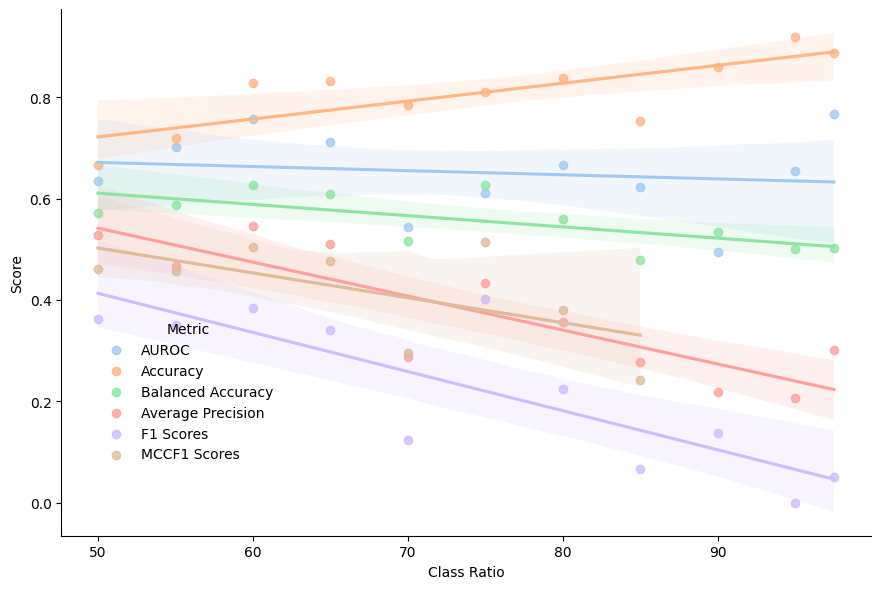

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12,6))
ax = sns.lmplot(
    data=linePlotDf,
    x='Ratio',
    y='Score',
    hue='Metric',
    palette=sns.color_palette("pastel"),
    height=6,
    aspect=1.5,
    # lowess=True,
    # scatter_kws={"s": 0},
    )
ax.set(xlabel='Class Ratio')
ax.set(ylabel='Score')
sns.move_legend(ax, "lower left", bbox_to_anchor=(.1, .2))
plt.show()
